In [1]:
# import required libraries

import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc

from matplotlib import pyplot as plt
import numpy as np

In [2]:
# Load the dataset
data = pd.read_csv('parkinsons.data')  # Replace 'your_dataset.csv' with the actual file name

In [3]:
# Separate features (X) and target (y)
X = data.drop(['name', 'status'], axis=1)  # Remove 'name' column and keep all features except 'status'
y = data['status']  # Target variable

In [4]:
# Split the dataset into training and testing sets
# First, split the data into train_val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=7,stratify=y)

# Next, split the train_val set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=7,stratify=y_train_val)

In [5]:
# Standardize features
scaler = StandardScaler()

X_train_val = scaler.fit_transform(X_train_val)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [6]:
solvers = ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']
penalties = ['l1', 'l2', None]  
best_accuracy = 0
best_model = None
best_solver = None
best_penalty = None

for solver in solvers:
    for penal in penalties:
        if solver == 'lbfgs' and penal == 'l1':
            continue 
        if solver == 'newton-cg' and penal == 'l1':
            continue  
        if solver == 'liblinear' and penal is None:
            continue  
        if solver == 'sag' and penal == 'l1':
            continue

        model = LogisticRegression(solver=solver, penalty=penal, max_iter=3000,class_weight='balanced')
        model.fit(X_train, y_train)
        accuracy = model.score(X_val, y_val)
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model
            best_solver = solver
            best_penalty = penal

print(f"Najbolji model: Solver={best_solver}, Penalty={best_penalty}, Accuracy={best_accuracy}")

Najbolji model: Solver=sag, Penalty=None, Accuracy=0.7692307692307693


/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [7]:
# Model coef_
best_model.coef_

array([[ 0.67901703, -0.14872171, -0.03219552, -7.48258319,  3.31364473,
         4.4366792 , -3.98567855,  4.32964298,  1.37435539,  2.04648011,
        -1.91513583, -1.25350876,  4.35164015, -1.90371379,  0.72048274,
         1.22456308, -0.48888552,  0.05162258,  3.36265865,  1.45991791,
         0.523926  , -1.12373712]])

In [8]:
# Refiting model with both train and validation data
best_model.fit(X_train_val,y_train_val)

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(class_weight='balanced', max_iter=3000, penalty=None,
                   solver='sag')

In [9]:
N = len(data.keys())
print(N)
print(list(data.keys()))

24
['name', 'MDVP:Fo(Hz)', 'MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP', 'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'MDVP:APQ', 'Shimmer:DDA', 'NHR', 'HNR', 'status', 'RPDE', 'DFA', 'spread1', 'spread2', 'D2', 'PPE']


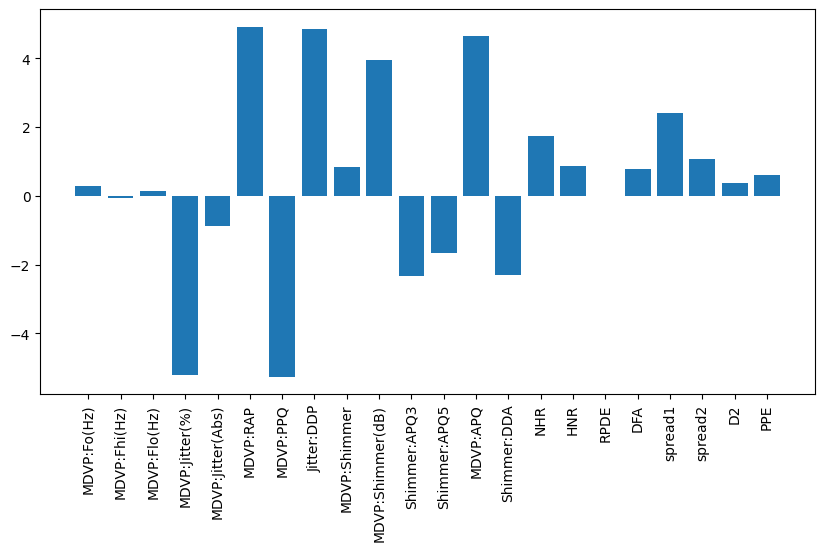

In [10]:
# Interpretation of intercept and coef values
N = len(list(X.keys()))
values = best_model.coef_[0]
plt.figure(figsize=(10, 5))
plt.bar(np.arange(0, N), values)
plt.xticks(np.arange(0, N), list(X.keys()), rotation='vertical')

plt.show()

In [11]:
# Predict on the test set
y_pred = best_model.predict(X_test)

In [12]:
# Evaluate the model
accuracy_lbfgs = accuracy_score(y_test, y_pred)
precision_score_lbfgs = precision_score(y_test, y_pred)
recall_score_lbfgs = recall_score(y_test, y_pred)
f1_score_lbfgs = f1_score(y_test, y_pred)
conf_matrix_lbfgs = confusion_matrix(y_test, y_pred)
class_report_lbfgs = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy_lbfgs:.2f}")
print(f"Precision score: {precision_score_lbfgs:.2f}")
print(f"Recall score: {recall_score_lbfgs:.2f}")
print(f"F1 score: {f1_score_lbfgs:.2f}")
print("Confusion Matrix:\n", conf_matrix_lbfgs)
print("Classification Report:\n", class_report_lbfgs)


Accuracy: 0.87
Precision score: 0.96
Recall score: 0.86
F1 score: 0.91
Confusion Matrix:
 [[ 9  1]
 [ 4 25]]
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.90      0.78        10
           1       0.96      0.86      0.91        29

    accuracy                           0.87        39
   macro avg       0.83      0.88      0.85        39
weighted avg       0.89      0.87      0.88        39



In [13]:
# Save model
import pickle

with open('../models/log_reg_classifier.model.pickle', 'wb') as model_file:
    pickle.dump(best_model, model_file)
    
with open('../models/log_reg_classifier.scaler.pickle', 'wb') as model_file:
    pickle.dump(scaler, model_file)